# Reproducing the benchmark model in Keras

In this notebook I reacreate the `beta model` from [here](https://github.com/emilwallner/Coloring-greyscale-images/blob/master/Beta-version/beta_version.ipynb) in order to see if I can replicate it and use it as a benchmark.

## Setup

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

In [1]:
!pip install gdown

# create directory for storing data
!mkdir -p images

# download zip file with training set
!gdown https://drive.google.com/uc?id=1rTf4DJI2PoM-hgSSSzvpOQcQhui3qh-y && unzip -qq train.zip -d images
!rm train.zip

# download zip with valid set
!gdown https://drive.google.com/uc?id=1yB-KN--FjiWZrA6XwxaSvtXhtcbk80dQ && unzip -qq valid.zip -d images
!rm valid.zip

# change dir to the one with data 
!cd /content

/bin/sh: gdown: command not found


In [11]:
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import h5py

from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave, imread, imshow
from skimage.transform import resize

import numpy as np
import os
import random


In [2]:
IMG_SIZE = 256
N_EPOCHS = 100
BATCH_SIZE = 32

## Preparing the Data

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True)

train_set = train_datagen.flow_from_directory('images/train_small/',
                                              target_size = (IMG_SIZE, IMG_SIZE),
                                              batch_size = BATCH_SIZE)

valid_datagen = ImageDataGenerator(rescale = 1./255)

valid_set = valid_datagen.flow_from_directory('images/valid_small/',
                                              target_size = (IMG_SIZE, IMG_SIZE),
                                              batch_size = BATCH_SIZE)

def gen_ab_images(train_set):
    for batch in train_set:
        lab_batch = rgb2lab(batch[0])
        X_batch = lab_batch[:,:,:,0] / 100
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)



Found 3 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


In [4]:
test = next(gen_ab_images(train_set))

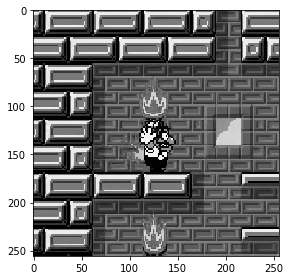

In [18]:
imshow(test[0][2][:, :, 0])

In [19]:
test[0][2][:, :, 0]

array([[0.51029833, 0.51986581, 0.50725976, ..., 0.47296511, 0.47296511,
        0.47296511],
       [0.49447386, 0.46423626, 0.49139484, ..., 0.49687553, 0.49687553,
        0.49687553],
       [0.93861896, 0.94720621, 0.93273522, ..., 0.91287637, 0.91287637,
        0.91287637],
       ...,
       [0.00158295, 0.00432468, 0.00588972, ..., 0.17921013, 0.27667244,
        0.30675658],
       [0.00158295, 0.00432468, 0.00588972, ..., 0.49197818, 0.57017141,
        0.59706012],
       [0.00138508, 0.00490777, 0.00588972, ..., 0.48963293, 0.56793799,
        0.59486016]])

## Model

In [5]:
model = Sequential()
model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='rmsprop', loss='mse')

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 512)      

## Training the model

In [7]:
tensorboard = TensorBoard(log_dir="output/first_run")
model.fit(x=gen_ab_images(train_set), 
          callbacks=[tensorboard], 
          epochs=N_EPOCHS, 
          validation_data=gen_ab_images(valid_set), 
          steps_per_epoch=len(train_set),
          validation_steps=len(valid_set))

Epoch 1/10
10/10 [==============================] - 30s 3s/step - loss: 0.1314
Epoch 2/10
10/10 [==============================] - 30s 3s/step - loss: 0.0200
Epoch 3/10
10/10 [==============================] - 31s 3s/step - loss: 0.0198
Epoch 4/10
10/10 [==============================] - 30s 3s/step - loss: 0.0197
Epoch 5/10
10/10 [==============================] - 31s 3s/step - loss: 0.0196
Epoch 6/10
10/10 [==============================] - 32s 3s/step - loss: 0.0200
Epoch 7/10
10/10 [==============================] - 32s 3s/step - loss: 0.0200
Epoch 8/10
10/10 [==============================] - 31s 3s/step - loss: 0.0199
Epoch 9/10
10/10 [==============================] - 31s 3s/step - loss: 0.0196
Epoch 10/10
10/10 [==============================] - 31s 3s/step - loss: 0.0200


In [12]:
# Save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

ImportError: `save_weights` requires h5py.

## Evaluation

In [14]:
batch = next(gen_ab_images(valid_set))
Xtest, Ytest = batch[0], batch[1]

Found 100 images belonging to 1 classes.


In [16]:
print(model.evaluate(Xtest, Ytest, batch_size=BATCH_SIZE))

10/10 [==============================] - 1s 85ms/step
0.01884119212627411


In [30]:
# Test model
output = model.predict(Xtest)
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = Xtest[i][:,:,0] * 100
    cur[:,:,1:] = output[i]
    cur = lab2rgb(cur)
    imsave("result/img_"+str(i)+".jpg", cur)

/Users/eryklewinson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: result/img_0.jpg is a low contrast image
  # Remove the CWD from sys.path while we load stuff.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/eryklewinson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: result/img_1.jpg is a low contrast image
  # Remove the CWD from sys.path while we load stuff.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/eryklewinson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: result/img_2.jpg is a low contrast image
  # Remove the CWD from sys.path while we load stuff.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/eryklewinson/anaconda3/lib/python3.7/site-packages/ipykernel

In [25]:
from skimage.io import imshow

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


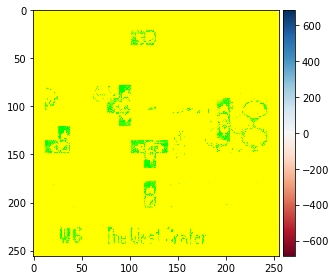

In [31]:
imshow(cur)

In [27]:
cur


array([[[ 0.4545867 ,  3.48246193, -0.33648652],
        [ 0.46727827,  3.48246193, -0.33648652],
        [ 0.4549881 ,  3.54871869, -0.30192491],
        ...,
        [ 0.45254043,  3.70320916, -0.06993626],
        [ 0.47529126,  2.29677939,  0.0827397 ],
        [ 0.47149232,  2.29677939,  0.0827397 ]],

       [[ 0.45125135,  3.48246193, -0.33648652],
        [ 0.45995812,  3.48246193, -0.33648652],
        [ 0.46327682,  3.54871869, -0.30192491],
        ...,
        [ 0.44313726,  3.70320916, -0.06993626],
        [ 0.46876495,  2.29677939,  0.0827397 ],
        [ 0.46963263,  2.29677939,  0.0827397 ]],

       [[ 0.46155323,  4.42870808, -0.57408154],
        [ 0.46366798,  4.42870808, -0.57408154],
        [ 0.46920554,  5.09976912, -0.42729411],
        ...,
        [ 0.44609522,  5.18652725, -0.37794194],
        [ 0.45770924,  3.03334856, -0.42493728],
        [ 0.46235812,  3.03334856, -0.42493728]],

       ...,

       [[ 0.46554218,  4.46204519, -0.39664051],
        [ 0